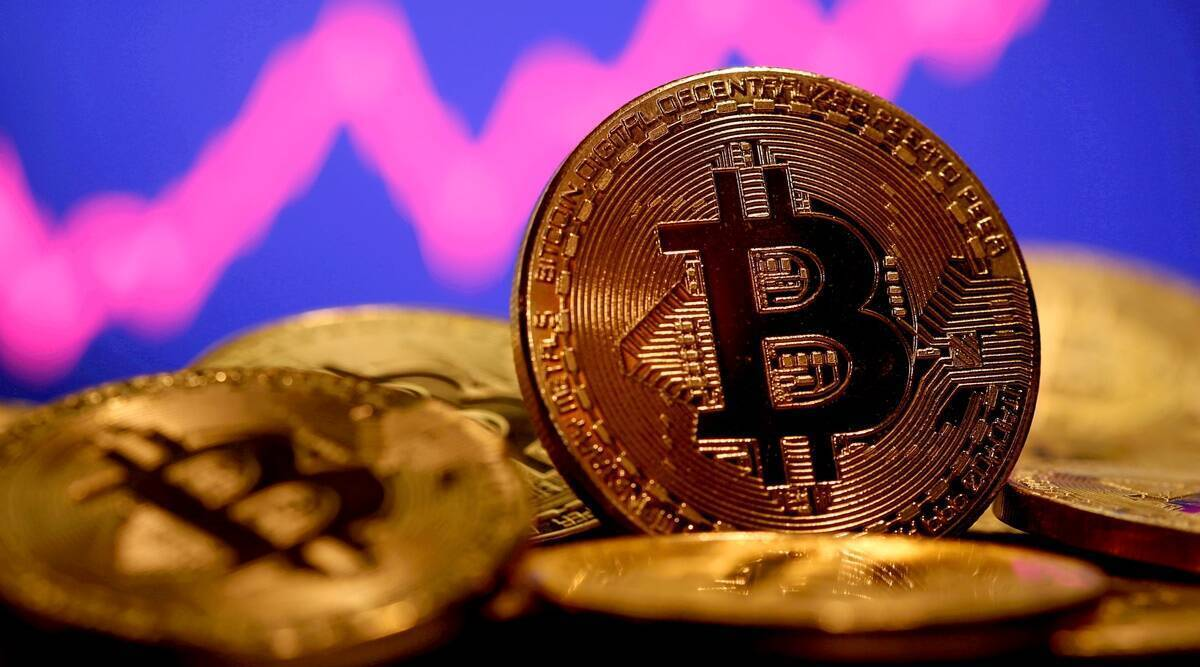

# BTC Prediction Model

## Overview

This project uses bitcoin (BTC) historical data from November of 2015 through November of 2021. The goal was to build a model that could create a roughly accurate  short term price prediction for the cryptocurrency. Additionally, it was used as a personal research study to determine the current ability of semi-basic modelling to predict the price movements of BTC. The notebook contains sections pertaining to exploratory data analysis (EDA) and data cleaning, ARIMA modelling, and the Long Short-term Neural Network.  

## Business Problem

- My stakeholder is the everyday common investor looking to invest in cryptocurrencies but are discouraged due to the volatility.
- To try and alleviate some of this volatility, I aim to create a simple model that can roughly (by roughly, I mean predict a positive or negative price movement) predict the price of bitcoin.
- Doing so would be able to help give traders insight as to where the price of BTC will be in the near future. 
- The model does not aim to accurately predict the exact price movements for bitcoin and therefore should not be expected to be used as a way to 'beat' the market.

## Data Understanding

- The data represents the last six years (November 2015 - November 2021 of BTC price and volume data and was sourced from yahoo Finance.
- The data includes the Volume, High and Low prices, and the Open, Close and Adjusted Close prices for each day. 
- Another column was added to the data, that being the percent change for each day.
- The target variable for the ARIMA model will be the percent change data, as an adfuller test indicated that it was stationary.
- The target variable for the Neural Network will be the Adjusted Close prices.
- All of the data, besides the date, are floats.

In [1]:
#Importing all necesarry functions and libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.arima.stationarity import ADFTest
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

## EDA and Data Cleaning

In [ ]:
#Reading the dataset and saving as 'all_btc' using pandas.

all_btc = pd.read_csv('../Data/BTC-USD.csv')

In [ ]:
#Changing the date to datetime format and setting the date as the index.

all_btc.Date = pd.to_datetime(all_btc.Date, format='%Y-%m-%d')
all_btc = all_btc.set_index('Date')
all_btc

In [ ]:
#Creating a percent change column for the adjusted close data, as this will likely create
#more stationary data.

all_btc['Percent change'] = all_btc['Adj Close'].pct_change()

In [ ]:
#Exploring null values in the adjusted close column in the dataset.

all_btc['Adj Close'].isnull().sum()

In [ ]:
#Filling null values in the dataframe using their most previous values.

all_btc = all_btc.fillna(method='pad')
all_btc

In [ ]:
#Visualizing the adjusted close versus time for the dataset. Movements
#appear to be completely random.

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

SMALL_SIZE = 16
MEDIUM_SIZE = 24
BIGGER_SIZE = 30

plt.figure(figsize=(12, 8))
plt.plot(all_btc['Adj Close'])
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.xlabel('Date')
plt.ylabel('Adjusted Close', )
plt.title('BTC Adjusted Close, 2015-Present')
plt.show()

In [ ]:
#Visualizing the 'percent change' data versus time. This graph  still
#looks random but it seems more manageable.

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

SMALL_SIZE = 16
MEDIUM_SIZE = 24
BIGGER_SIZE = 30

plt.figure(figsize=(12, 8))
plt.plot(all_btc['Percent Change'])
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.xlabel('Date')
plt.ylabel('Percent Change', )
plt.title('BTC Daily Percent Change, 2015-Present')
plt.show()

In [ ]:
#importing and running adfuller test on the adjusted close and percent change columns.
#The null hypothesis: The data is non stationary
#The alternative: The data is stationary

af_close = adfuller(all_btc['Adj Close'])
af_pct = adfuller(all_btc['Percent change'][1:2193])
af_close

In [ ]:
#adfuller test for the percent change column shows that it is very 
#stationary because the p value (0.0) is much smaller than 0.05.

af_pct

In [ ]:
#Plotting the autocorrelation function for percent change.

plot_acf(all_btc['Percent change'].dropna(), lags=40)

In [ ]:
#Plotting the partial autocorrelation function for percent change.

plot_pacf(all_btc['Percent change'].dropna(), lags=40)

## ARIMA

In [ ]:
#Fitting the ARIMA model and viewing the summary statistics for it.

first_model = ARIMA(all_btc['Percent change'], order=(1,1,1))
first_model_fit = first_model.fit()
first_model_fit.summary()

In [ ]:
#Viewing the predictions made by the first ARIMA model. As we can
#see, it did not work very well. Because of this, we will try auto
#ARIMA and then move on to a neural network.

predictions = first_model_fit.predict(start=2180, end=2200, dynamic=True)
predictions

In [ ]:
#Comparing the predictions to the actual values.

all_btc.tail(20)

In [ ]:
#Performing an Augmented Dickey-Fuller test to determine whether the
#percent change data needed to be differenced prior to using auto
#ARIMA

adf_test = ADFTest(alpha=0.05)

p_val, should_diff = adf_test.should_diff(all_btc['Percent change'][1:2193].fillna(method='pad'))

print('P-val: ', p_val)
print('Difference data? ', should_diff)

In [ ]:
#Creating the train, test, and validation sets of data to perform auto ARIMA on.

train, test, val = (all_btc['Percent change'][1:2100], all_btc['Percent change'][2100:2160],
                    all_btc['Percent change'][2160:2193])

In [ ]:
#Performing auto ARIMA on the training set.

arima = pm.auto_arima(train, error_action='ignore', trace=True, supress_warnings=True,
                     maxiter=100, seasonal=False)

In [ ]:
#Looking at the summary statistics for the auto ARIMA. 
#Best model: ARIMA(1,0,0)(0,0,0)[0] intercept

arima.summary()

In [ ]:
#Looking at the predictions made form using auto ARIMA. Once again, 
#the predictions do not seem sufficient.

arima.predict(X=val)

## Neural Network

In [ ]:
#Creating a series type dataset for the adjusted close data and
#inspecting the first 15 rows.

adj_close_series = pd.Series(data=all_btc['Adj Close'], index=all_btc.index)
adj_close_series.head(15)

In [ ]:
#Creating a series type dataset for the percent change data. This 
#will likely not be used as of yet but could be utilized in the future.

pct_change_series = pd.Series(data=all_btc['Percent Change'], index=all_btc.index)
pct_change_series.head(15)

In [ ]:
#Defining a function to create a 'supervised' dataset.

def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [ ]:
#Using the timeseries_to_supervised function to create a supervised 
#dataset for the adjusted close data.

adj_supervised = timeseries_to_supervised(adj_close_series)

In [ ]:
#Defining a funtion that will difference a dataset for me.

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [ ]:
#Differencing the supervised adjusted close dataset.

adj_close_diff = difference(adj_supervised)

In [ ]:
#Performing a train, test, validation split of the adjusted close data.

train_adj, test_adj, val_adj = (adj_close_diff[0:2100], 
                                adj_close_diff[2100:2160],
                                adj_close_diff[2160:])

In [ ]:
#Creating function that will scale data for me using the MinMax Scaler.

def scale(train, test):
    scaler=MinMaxScaler(feature_range=(-1, 1))
    #Training data
    scaler.fit(train)
    train_scaled = scaler.transform(train)
    #Testing data
    scaler.fit(test)
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [ ]:
#Scaling the test and train datasets using the MinMax scaler that is
#contained within the previously defined 'scale' function.

scaler, train_scaled_adj, test_scaled_adj = scale(train_adj, test_adj)

In [ ]:
#Defining function to fit a Long Short-term Memory neural network to the data.

def fit_LSTM(train, batch_size, n_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], 
                                              X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
    for i in range (n_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [ ]:
#Creating a function that will provide a forecast for a long short-term
#memory neural netowkr to be used in forming the predictions.

def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [ ]:
#Fitting the first long short-term memory neural network on the 

lstm_model = fit_LSTM(train_scaled_adj, 50, 2000, 3)

In [ ]:
#Reshaping the training data and saving it as a new dataset to be used
#in forming the predictions for our model.

train_reshaped_adj = train_scaled_adj[:, 0].reshape(len(train_scaled_adj), 1, 1)

In [ ]:
#Creating a list of predictions from our first LSTM model. As we can
#see, it does not perform overly well

predictions = list()
for i in range(len(test_scaled_adj)):
    # make one-step forecast
    X, y = test_scaled_adj[i, 0:-1], test_scaled_adj[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scaler(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(adj_close_series.values, yhat, len(test_scaled_adj)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = adj_close_series.values[len(train_adj) + i + 1]
    print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

In [ ]:
#Fitting the final LSTM.

final_lstm = fit_LSTM(train_scaled_adj, 10, 2000, 4)

In [ ]:
#Looking at the predictions made using the final LSTM. Once again,
#the predictions are not great, however, at least we begin to see both
#positive and negative movement in our predictoins.

predictions = list()
for i in range(len(test_scaled_adj)):
    # make one-step forecast
    X, y = test_scaled_adj[i, 0:-1], test_scaled_adj[i, -1]
    yhat = forecast_lstm(final_lstm, 1, X)
    # invert scaling
    yhat = invert_scaler(scaler, X, yhat)
    # invert differencing
    Predicted = inverse_difference(adj_close_series.values, yhat, len(test_scaled_adj)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = adj_close_series.values[len(train_adj) + i + 1]
    print('Day=%d, Predicted=%f, Expected=%f' % (i+1, Predicted, expected))

In [ ]:
#Matching up the predictions with the correct day. The third prediction corresponds with the first record shown.
#The date being 2021-08-24

all_btc.tail(90)